# DeepDream

Сегодня мы воспроизведём известную работу Александра Мордвинцева и соавторов, [заметку](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) о которой они опубликовали в июне 2015 года.

![](https://lh3.googleusercontent.com/pw/ACtC-3emSpI1T1ILEk-DUKMXgtfyfdmsCOPTvPLyvUK-UoY0-iXOPGrxoLzlm_FbToUwaK-wCs_Mcgo7Yaodyd9spacJIR6xhrlMJYJX2XqIIYYxeYJ5h8-EDzCy5mb6a8eBTl0nZqdaqpY4LYtEPV1SjBF4=w716-h448-no)

Этот ноутбук сделан на основе двух источников:

* [Сторонняя реализация на PyTorch](https://github.com/eriklindernoren/PyTorch-Deep-Dream)
* [Оригинальная реализация на Caffe](https://github.com/google/deepdream)

In [1]:
import io

import requests
from PIL import Image
from tqdm.notebook import tqdm

import numpy as np
import scipy.ndimage as nd

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, models

# 1. Загружаем картинку

Экспериментировать будем на Мона Лизе.

In [2]:
def get_image(url):
    response = requests.get(url)
    return Image.open(io.BytesIO(response.content))

In [3]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/515px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg'

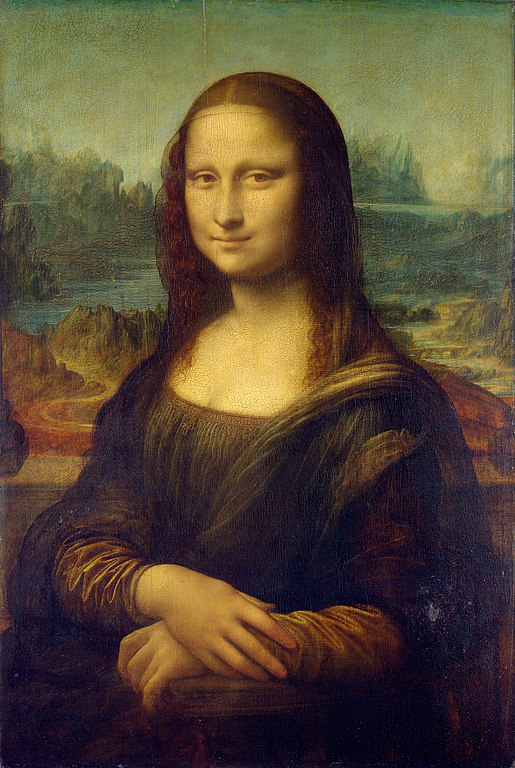

In [4]:
# Load image
image = get_image(url)
image

# 2. Скачиваем предобученную модель

Общая идея — это сгенерировать картинку, которая будет вызывать сильную активацию одного из промежуточных слоёв в какой-то классификационной нейронке. Например, в одном из свёрточных слоёв VGG-19.

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [6]:
# Загрузите предобученную модель VGG-19
network = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [7]:
network

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
# Извлеките из неё свёрточную часть
feature_extractor = network.features

# Перенесите её на GPU
feature_extractor = feature_extractor.to(device)

# (Не обязательно конкретно для vgg19.features): переведите модель в eval mode
feature_extractor.eval()

# Отключите подсчёт градиентов по её параметрам
for p in feature_extractor.parameters():
    p.requires_grad = False

feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

В случае со свёрточной частью VGG-19 наша жизнь сильно упрощается тем, что это всего-навсего `nn.Sequential`, который имеет интерфейс, как у обычного питоновского списка. Это позволит нам очень легко добывать промежуточные активации.

In [9]:
len(feature_extractor)

37

In [10]:
feature_extractor[:10]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [11]:
X = torch.randn(1, 3, 224, 224).to(device)
activations = feature_extractor[:10](X)
activations.shape

torch.Size([1, 128, 56, 56])

# 3. Реализуем алгоритм

Базово DeepDream — это всего лишь максимизация суммы квадратов (т.е. квадрата $L_2$-нормы) активаций некоторого промежуточного слоя.

$$
\mathbf{h} = \operatorname{submodel}(\mathbf{x}) \\
\sum_i h_i^2 \to \max_{\mathbf{x}}
$$

Делать это мы будем градиентным спуском: будем в течение нескольких итераций считать градиент $\sum_i h_i^2$ по $\mathbf{x}$ и делать шаг **по** градиенту (не против, т.к. мы максимизируем это число).

$$
\begin{align*}
L &= \sum_i h_i^2 \\
g^{(t)} &= \frac {\partial L} {\partial \mathbf{x}^{(t)}} \\
\mathbf{x}^{(t + 1)} &= \mathbf{x}^{(t)} + \lambda^{(t)} g^{(t)}
\end{align*}
$$

In [12]:
def compute_deepdream_grad(submodel, x):
    submodel_input = x.detach()
    submodel_input.requires_grad = True
    
    # Вычислите активации на выходе подмодели, посчитайте сумму их квадратов и верните градиент
    h = submodel(submodel_input)
    L = (h**2).sum()
    L.backward()
    
    return submodel_input.grad

Вокруг этой процедуры оптимизации в DeepDream применяется несколько костылей, чтобы картинки получались лучше. Будем реализовывать их по очереди.

Во-первых, перед каждым вычислением и применением градиентов картинка параллельно сдвигается на случайный вектор, а после применения градиентов сдвигается обратно.

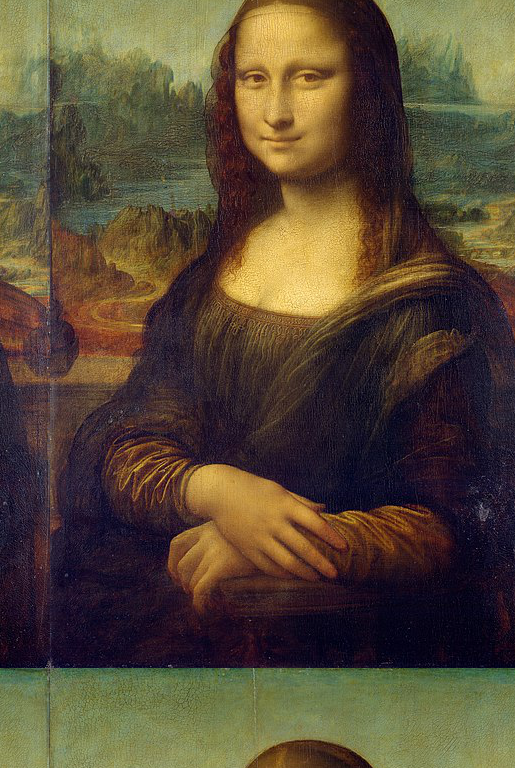

In [13]:
def shift_tensor(tensor, shift_h, shift_w):
    return torch.roll(tensor, shifts=(shift_h, shift_w), dims=(1, 2))

Image.fromarray(
    shift_tensor(
        torch.tensor(np.array(image)).permute(2, 0, 1),
        shift_h=-100,
        shift_w=50,
    ).permute(1, 2, 0).numpy()
)

Во-вторых, после каждого применения градиентов значения пикселей в тензоре обрезаются таким образом, чтобы не выходить за допустимые границы. Если бы мы работали с тензором в диапазоне `[0..1]` или `[0..255]`, то для такого обрезания было бы достаточно вызвать `torch.clamp(image, 0, 1)` (или, соответственно, `torch.clamp(image, 0, 255)`). Но мы работаем с изображениями в нормализации ImageNet, а поддержку границ-тензоров [добавили](https://github.com/pytorch/pytorch/pull/52695) в `torch.clamp` только 3 мая 2021 года, и на момент написания этого ноутбука эти изменения ещё не попали в релиз. Поэтому нам нужно реализовать самостоятельно разную нормировку для разных каналов.

In [14]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

In [15]:
def clamp(image_tensor):
    """
    Clamp each channel in image_tensor (1x3xHxW torch.Tensor) to ImageNet normalization.
    """
    # Посчитайте два np.array из трёх элементов каждый: минимальные и максимальные значения для тензоров,
    # отнормированных при помощи IMAGENET_MEAN и IMAGENET_STD. Это значит, что до нормировки тензоры имели
    # значения от 0 до 1 в каждом канале, но потом разные каналы отнормировали по-разному: из элементов
    # канала `c` вычли IMAGENET_MEAN[c] и разделили на IMAGENET_STD[c].

    # x -> (x - mean) / std
    # x_min = 0
    # x_max = 1 

    lo = -IMAGENET_MEAN / IMAGENET_STD
    hi = (1 - IMAGENET_MEAN) / IMAGENET_STD
    for c in range(3):
        image_tensor[:, c] = torch.clamp(image_tensor[:, c], lo[c], hi[c])
    return image_tensor

В-третьих, $\lambda^{(t)}$ — не константа. Этот коэффициент вычисляется так:

$$
\lambda^{(t)} = \frac \lambda { \frac 1 n \sum_{j = 1}^n |g^{(t)}_j| }
$$

Теперь напишем собственно цикл оптимизации.

In [16]:
def dream(image, submodel, iterations, lr, jitter):
    """ Updates the image to maximize outputs for n iterations """
    for _ in range(iterations):
        # Сгенерируйте shift_h и shift_w от -jitter до jitter каждый и сдвиньте image на (shift_h, shift_w)
        shift_h, shift_w = np.random.randint(-jitter, jitter + 1, size=2)
        image = shift_tensor(image, shift_h, shift_w)
        
        # Посчитайте градиент
        image_grad = compute_deepdream_grad(submodel, image)
        
        # Посчитайте отнормированный learning rate
        lambda_t = lr / image_grad.abs().mean()
        
        # Обновите image: сделайте шаг вдоль градиента и обрежьте значения пикселей
        image = image + lambda_t * image_grad
        image = clamp(image)
        
        # Не забудьте сдвинуть image обратно!
        image = shift_tensor(image, -shift_h, -shift_w)
    return image

Давайте проверим, что у нас получается.

In [17]:
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


def torch_image_to_numpy(image_torch):
    """Convert PyTorch tensor to Numpy array.
    :param image_torch: ImageNet-normalized PyTorch float CHW Tensor.
    :returns: Numpy uint8 HWC array in range [0..255].
    """
    image_np = image_torch.permute(1, 2, 0).numpy()
    image_np = image_np * IMAGENET_STD + IMAGENET_MEAN
    image_np = image_np * 255 + 0.5
    image_np = np.clip(image_np, 0, 255)
    image_np = image_np.astype(np.uint8)
    return image_np

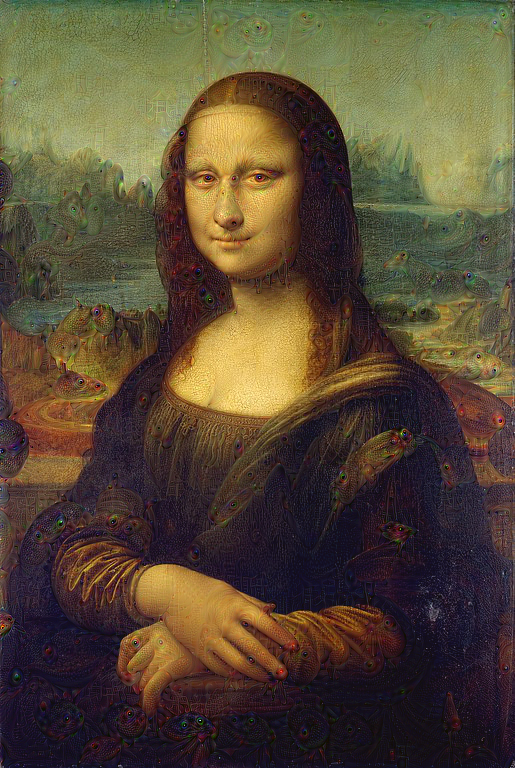

In [18]:
dreamed_image = torch_image_to_numpy(
    dream(
        transform_pipeline(image).unsqueeze(0).to(device),
        feature_extractor[:28],
        iterations=20,
        lr=0.01,
        jitter=32,
    ).cpu().squeeze(dim=0)
)

Image.fromarray(dreamed_image)

Видны некоторые интересные эффекты, но как-то слабовато.

Чтобы усилить эффект, в DeepDream применяется ещё один костыль: вычисления на разных масштабах. Из изображения делается целая серия изображений, где каждое следующее изображение больше предыдущего. В оригинальном коде такие изображения называются "октавы". Мы будем называть всю такую серию изображений "пирамидой", поскольку такое название более распространено.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


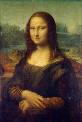

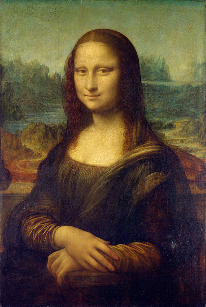

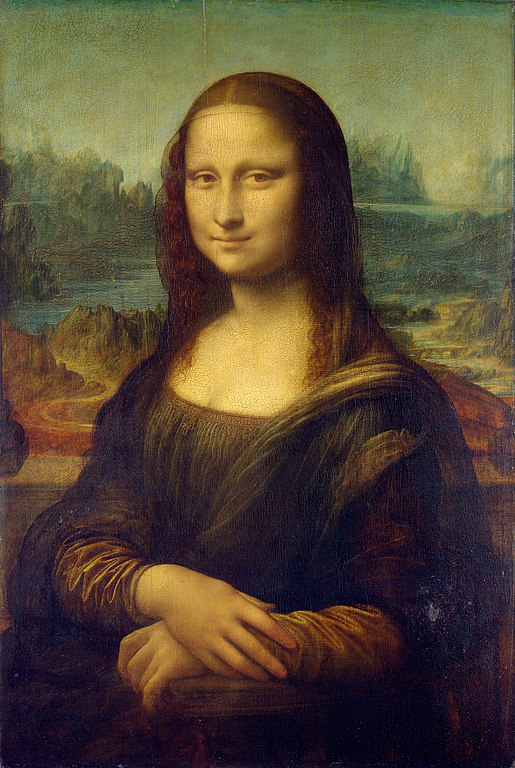

In [19]:
from IPython.display import display


def make_image_pyramid(image, scale_step, num_scales):
    """Returns a list of length `num_scales` where the *last* element is equal to `image`,
    and each of the other elements is `scale_step` times smaller than the one after it."""
    
    # Подсказка: здесь пригодится функция torch.nn.functional.interpolate. Используйте mode='bilinear'.
    
    pyramid = [image]
    for _ in range(num_scales - 1):
        pyramid.append(
            F.interpolate(pyramid[-1], scale_factor=1/scale_step, mode='bilinear')
        )
    pyramid = pyramid[::-1]
    
    return pyramid

pyramid = make_image_pyramid(transform_pipeline(image).unsqueeze(0).to(device), scale_step=2.5, num_scales=3)
for item in pyramid:
    display(Image.fromarray(torch_image_to_numpy(item.squeeze(dim=0).cpu())))
del pyramid

Пирамиду мы используем для того, чтобы посчитать галлюцинации DeepDream на каждом из её масштабов, начиная с самого маленького.

In [23]:
from IPython.display import display


def deep_dream(image, model, iterations=20, lr=0.01, scale_step=1.4, num_scales=10, jitter=32):
    """ Main deep dream method """
    image = transform_pipeline(image).unsqueeze(dim=0).to(device)
    
    # Посчитайте пирамиду
    pyramid = make_image_pyramid(image, scale_step, num_scales)

    # Здесь мы будем поддерживать то, что уже посчитали на более мелких масштабах.
    # Тут будут только артефакты DeepDream, без самого изображения.
    deep_dream_detail = torch.zeros_like(pyramid[0])
    
    for scale_idx, scale in enumerate(tqdm(pyramid)):
        if scale_idx > 0:
            # Отмасштабируйте deep_dream_detail до размеров нового уровня пирамиды.
            # Используйте torch.nn.functional.interpolate с mode='bilinear'.
            deep_dream_detail = F.interpolate(deep_dream_detail, size=scale.shape[2:], mode='bilinear')

        # Добавьте посчитанные ранее артефакты к новому уровню пирамиды
        input_image = scale + deep_dream_detail
        
        # Обновите картинку с артефактами
        dreamed_image = dream(input_image, model, iterations, lr, jitter)
        
        display(Image.fromarray(torch_image_to_numpy(dreamed_image.cpu().squeeze(dim=0))))
        
        # Уберите картинку из пирамиды из артефактов
        deep_dream_detail = dreamed_image - scale
    
    return torch_image_to_numpy(dreamed_image.cpu().squeeze(dim=0))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


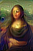

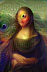

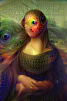

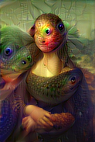

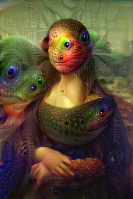

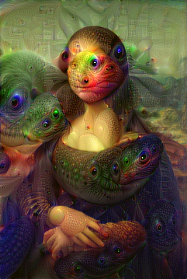

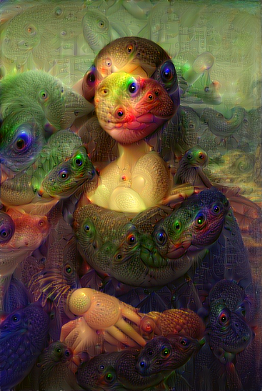

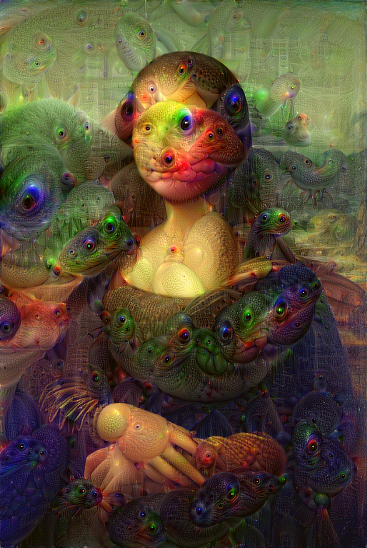

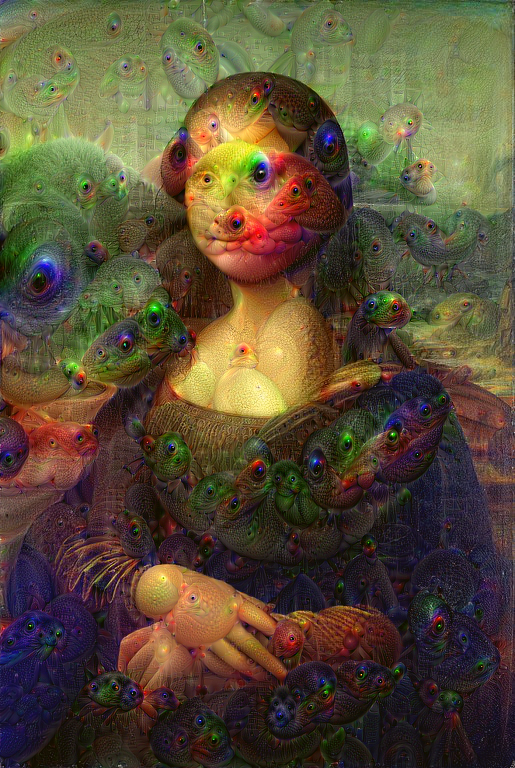

In [24]:
dreamed_image = deep_dream(image, feature_extractor[:28])

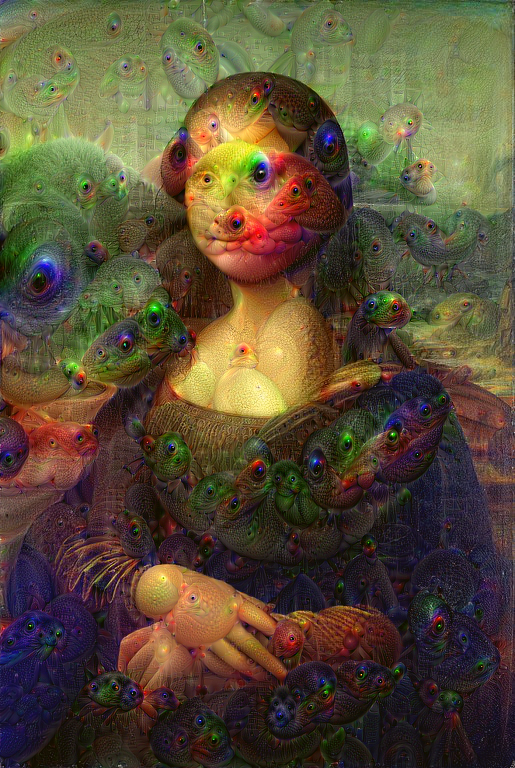

In [25]:
Image.fromarray(dreamed_image)